In [ ]:
#Setup
!git clone https://github.com/ibiann/NLP-GR9.git

In [63]:
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
import numpy as np
from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import CountVectorizer
import random
from random import sample

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Prepare dataset

In [64]:
pre_load = pd.read_csv('/content/NLP-GR9/spam_or_not_spam.csv')

In [65]:
data = pre_load.sample(frac=1) # shuffle dataset

In [66]:
data.head(5)

,email,label
2094,url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...,0
1380,it s this section of spamassassin raw spamass...,0
777,russell turpin wrote invite her for an afterno...,0
516,so eugen how many of your homo friends have h...,0
564,gays gay sex gay marriage wooohooo its been a...,0


In [67]:
data.describe()

,label
count,3000.000000
mean,0.166667
std,0.372740
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [68]:
data = data.dropna()

In [69]:
print(type(data['label']))

<class 'pandas.core.series.Series'>


Preprocess

In [70]:
english_stopwords = set(stopwords.words('english'))
punc_set = set(string.punctuation)
punc_set.add("``")
ps = PorterStemmer()
def preprocess_email(text):
    preprocessed_tokens = []
    text = text.lower()
    tokens = word_tokenize(text)

    tokens = word_tokenize(text)
    for tok in tokens:
        if tok in english_stopwords or tok == " " or tok in punc_set:
            continue
        tok = re.sub(r"\d+", "NUMBER", tok)
        ps.stem(tok)
        preprocessed_tokens.append(tok)

    return " ".join(preprocessed_tokens)

In [71]:
data['processed_email'] = data['email'].apply(preprocess_email)

In [72]:
data.head(-10)

,email,label,processed_email
2094,url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...,0,url url date number number numbertnumber numbe...
1380,it s this section of spamassassin raw spamass...,0,section spamassassin raw spamassassin raw snip...
777,russell turpin wrote invite her for an afterno...,0,russell turpin wrote invite afternoon cruise g...
516,so eugen how many of your homo friends have h...,0,eugen many homo friends numberk lovers fact th...
564,gays gay sex gay marriage wooohooo its been a...,0,gays gay sex gay marriage wooohooo mano e mano...
...,...,...,...
1867,url URL date wed NUMBER sep NUMBER NUMBER NUMB...,0,url url date wed number sep number number numb...
2592,get your favorite poker action at URL play aga...,1,get favorite poker action url play real people...
354,on wed NUMBER NUMBER NUMBER at NUMBER NUMBER g...,0,wed number number number number number gary la...
1829,url URL date NUMBER NUMBER NUMBER NUMBER NUMBE...,0,url url date number number number number numbe...


Most Common word

in spams:

In [73]:
spam_corpus = [] # spam
for msg in data[data['label'] == 1]['processed_email'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


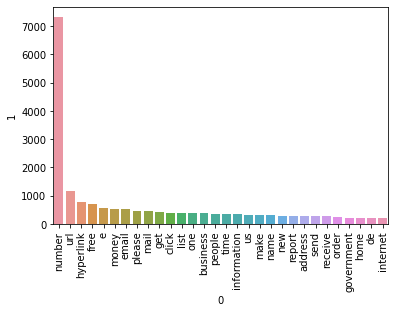

In [74]:
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1]) 
plt.xticks(rotation='vertical')
plt.show()

In [75]:
#issues will address in Word docx

In [76]:
wc_spam = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', 
               collocations=False).generate(data[data['label'] == 1]['processed_email'].str.cat(sep=" "))

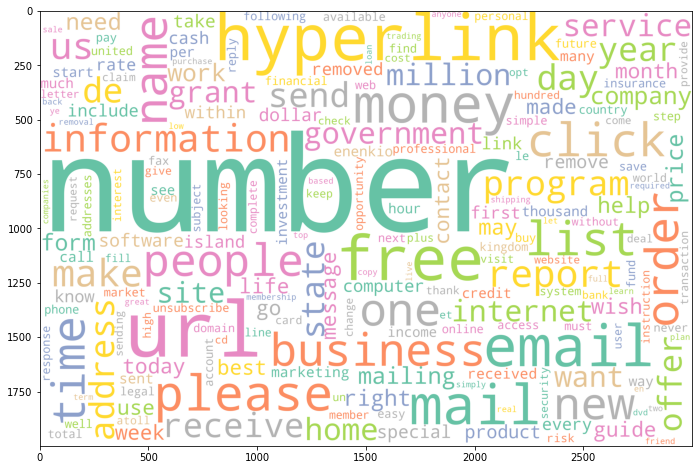

In [77]:
plt.figure(figsize=(15,8))
plt.imshow(wc_spam)

in non-spams:

In [78]:
ham_corpus = [] # ham
for msg in data[data['label'] == 0]['processed_email'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


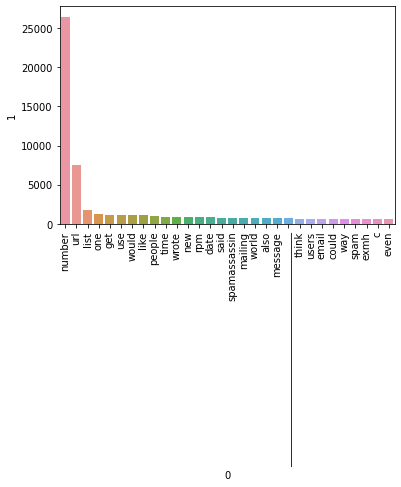

In [79]:
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1]) 
plt.xticks(rotation='vertical')
plt.show()

In [80]:
wc_ham = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', 
               collocations=False).generate(data[data['label'] == 0]['processed_email'].str.cat(sep=" "))

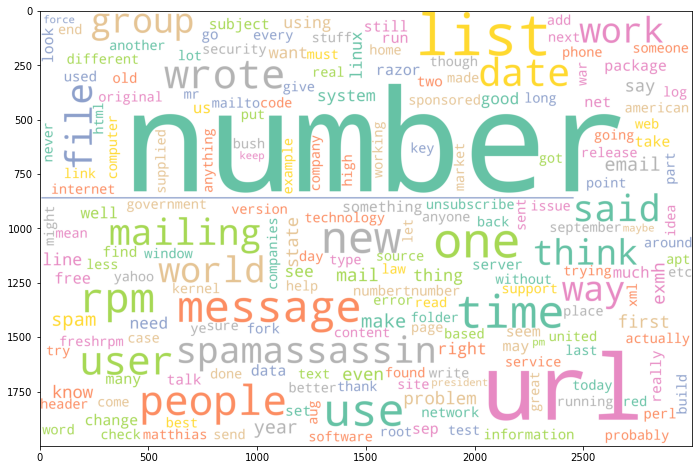

In [81]:
plt.figure(figsize=(15,8))
plt.imshow(wc_ham)

Sentence Analysis

In [82]:
#N-gram

In [83]:
data_spam = data[data['label'] == 1]
data_ham = data[data['label'] == 0]

In [84]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = tqdm(word_vectorizer.fit_transform(data['processed_email']),total=len(data['processed_email']))
frequencies = sum(sparse_matrix).toarray()[0]
print("Done")

  0%|          | 0/2999 [00:00<?, ?it/s]

Done


In [85]:
n_grams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by="frequency", ascending=False)
n_grams.describe()
n_grams.head(30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
number number,16978
url url,1520
number url,859
mailing list,783
url number,711
url date,638
rpm list,519
sep number,427
url _______________________________________________,377
date number,372


In [86]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = tqdm(word_vectorizer.fit_transform(data_spam['processed_email']),total=len(data_spam['processed_email']))
frequencies = sum(sparse_matrix).toarray()[0]
print("Done")

  0%|          | 0/499 [00:00<?, ?it/s]

Done


In [87]:
n_grams_spam = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by="frequency", ascending=False)
n_grams_spam.describe()
n_grams_spam.head(30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
number number,3034
hyperlink hyperlink,204
hyperlink click,182
report number,181
number million,104
url url,101
price number,84
email address,84
name address,83
number people,80


In [88]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = tqdm(word_vectorizer.fit_transform(data_ham['processed_email']),total=len(data_ham['processed_email']))
frequencies = sum(sparse_matrix).toarray()[0]
print("Done")

  0%|          | 0/2500 [00:00<?, ?it/s]

Done


In [89]:
n_grams_ham = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by="frequency", ascending=False)
n_grams_ham.describe()
n_grams_ham.head(30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency
number number,13944
url url,1419
number url,839
mailing list,713
url number,654
url date,637
rpm list,519
sep number,422
url _______________________________________________,370
date number,368


In [90]:
X =  data['email'].values
y = data['label'].values

In [91]:
vectorizer = CountVectorizer()
X_train1 = vectorizer.fit_transform(X.astype('U'))

In [92]:
X_train,X_test,y_train,y_test =  train_test_split(X_train1,y,test_size = 0.3 , random_state = 42 )

Choosing Algo

In [93]:
svc = SVC(probability=True)
score_1 = cross_val_score(svc,X_train,y_train,cv = 10)
score_1.mean()

0.9309250398724084

In [94]:
linear = LinearRegression()
score_2 = cross_val_score(linear,X_train,y_train,cv = 10)
score_2.mean()

-3.9879498761710623

Pick SVM

In [95]:
res = svc.fit(X_train, y_train)

In [96]:
labels_pred = res.predict(X_test)

In [97]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score

accuracy = accuracy_score(y_test, labels_pred)
precision = precision_score(y_test, labels_pred, average="binary", pos_label=1)
recall = recall_score(y_test, labels_pred, average="binary", pos_label=1)
f1 = f1_score(y_test, labels_pred, average="binary", pos_label=1)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 Score: %f' % f1)
print(classification_report(y_test, labels_pred))

Accuracy: 0.942222
Precision: 0.989474
Recall: 0.648276
F1 Score: 0.783333
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       755
           1       0.99      0.65      0.78       145

    accuracy                           0.94       900
   macro avg       0.96      0.82      0.88       900
weighted avg       0.95      0.94      0.94       900



Lime

In [99]:
!pip install lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, svc)

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=1d16ed5e3315d923a87c186501a48652a56f7753e2bd44757d632336be2ae010
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [100]:
print(type(X))

<class 'numpy.ndarray'>


In [101]:
from lime.lime_text import LimeTextExplainer


class_names=['0','1']
explainer = LimeTextExplainer(class_names=class_names)
idx = 30
exp = explainer.explain_instance(X[idx], c.predict_proba, num_features=6)
exp.as_list()

[('URL', -0.014973171228528794),
 ('link', 0.004740150523837308),
 ('date', -0.0041318576275658865),
 ('is', -0.004080671696296245),
 ('email', 0.0035152167651413945),
 ('url', -0.0033988122117038473)]

In [103]:
exp.show_in_notebook()